# Dataset 1 - realTweets/Twitter_volume_AMZN

## 0. What we’re doing and why

In this notebook, we focus on a single real‐world occupancy time series (“occupancy_6005” sampled every five minutes) to build and validate an EVT-ready preprocessing pipeline. 

In [3]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ruptures as rpt
import ads_evt as spot

from scipy.stats import genpareto, kstest
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import STL

# Load realTraffic dataset
df = pd.read_csv("../../data/raw_data/ec2_cpu_utilization_5f5533.csv", parse_dates=[0])
df.columns = ["timestamp", "value"]

## 1. Descriptive EDA

In [4]:
# Inspect the structure
print(df.head())
print(df.describe())

            timestamp   value
0 2014-02-14 14:27:00  51.846
1 2014-02-14 14:32:00  44.508
2 2014-02-14 14:37:00  41.244
3 2014-02-14 14:42:00  48.568
4 2014-02-14 14:47:00  46.714
                 timestamp        value
count                 4032  4032.000000
mean   2014-02-21 14:24:30    43.110372
min    2014-02-14 14:27:00    34.766000
25%    2014-02-18 02:25:45    39.296000
50%    2014-02-21 14:24:30    42.918000
75%    2014-02-25 02:23:15    46.006000
max    2014-02-28 14:22:00    68.092000
std                    NaN     4.303565


#### Main observations:
- Regular sampling every 5 minutes
- Range from 34 to 68

#### Implication for EVT-AD: 
good candidate for EVT since we have enough magnitude range.

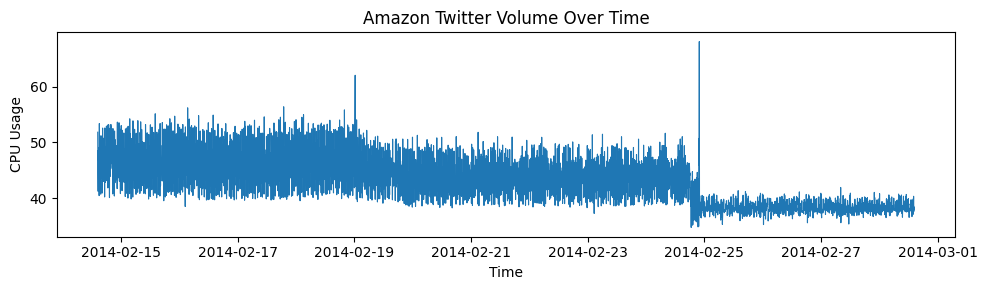

In [5]:
# Plot the raw series
plt.figure(figsize=(10,3))
plt.plot(df["timestamp"], df["value"], linewidth=0.8)
plt.title("Amazon Twitter Volume Over Time")
plt.xlabel("Time")
plt.ylabel("CPU Usage")
plt.tight_layout()
plt.show()

#### Main observations:
- Data spans Feb 15–MArch 1 with no gaps.
- Gradual drift downward. 
- A few of surge peaks.

#### Implications for EVT-AD:
Detrend (e.g. STL or rolling z-scores). Check the variance.

#### Now let's explore the type of drift in the dataset.

In order to detect the presence of the drift, we can use rolling statistics.

Rolling statistics let us see how the baseline (mean) and volatility (std) change over time, which is exactly what “concept drift” means.

#### What rolling window to choose?

The dataset is recorded every 5 minutes. One day has 24h × 60min / 5min = 288 samples. We dis not observe clear daily seasonality from the plot above so let's use 288.

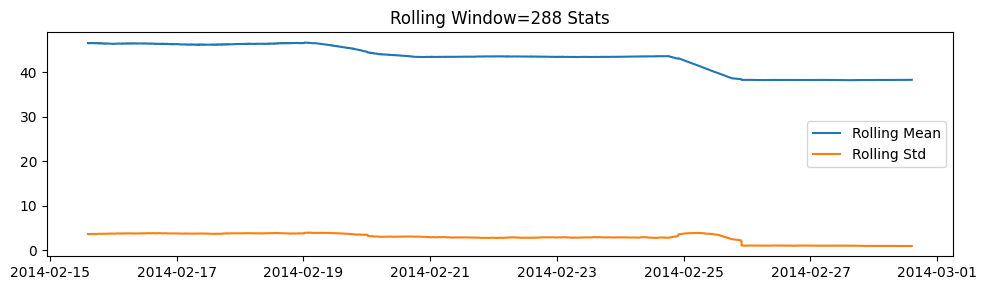

In [6]:
# Rolling statistics to visualise drift
window = 288
df["roll_mean"] = df["value"].rolling(window).mean()
df["roll_std"]  = df["value"].rolling(window).std()

# Plot the results
plt.figure(figsize=(10,3))
plt.plot(df["timestamp"], df["roll_mean"], label="Rolling Mean")
plt.plot(df["timestamp"], df["roll_std"],  label="Rolling Std")
plt.legend()
plt.title(f"Rolling Window={window} Stats")
plt.tight_layout()
plt.show()

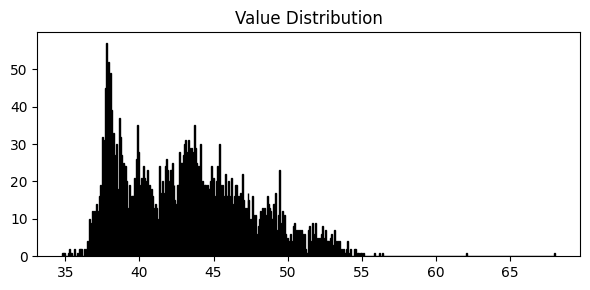

In [7]:
# Check the value distribution
plt.figure(figsize=(6,3))
plt.hist(df["value"], bins=500, edgecolor="k")
plt.title("Value Distribution")
plt.tight_layout()
plt.show()

#### Main observations:
1. Rolling mean and std drifts down over days.
2. No abrupt changes.
3. Raw values are resoanablly skewed: rare tail spikes to ~65.

#### Implication:
the most stable variance compared to other datasets that are used in this project

Now, let'c check the ACF 

<Figure size 800x300 with 0 Axes>

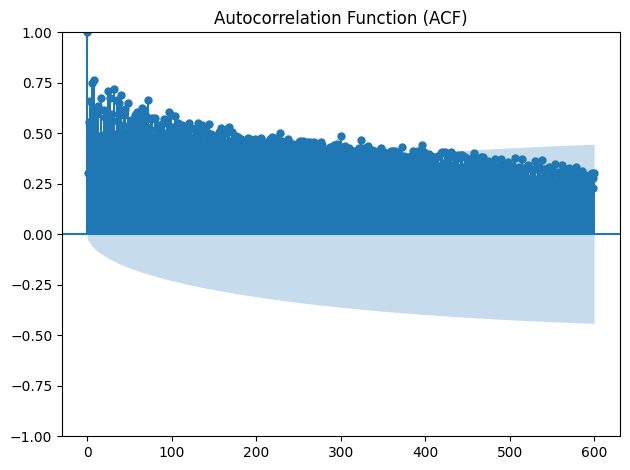

In [8]:
value = df["value"].values

plt.figure(figsize=(8, 3))
plot_acf(value, lags=600)
plt.title("Autocorrelation Function (ACF)")
plt.tight_layout()
plt.show()


No clear seasonal peaks. Present long‐memory behavior.

### 2. EVT Suitabilty Check

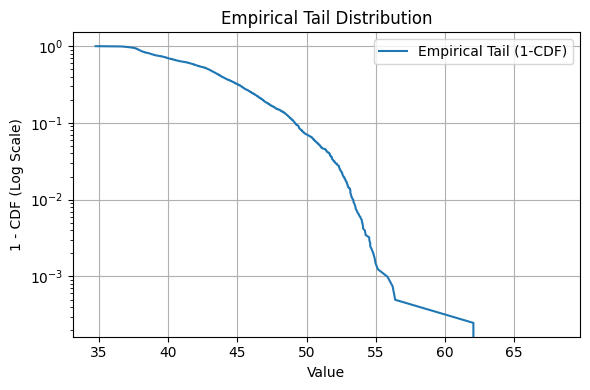

In [9]:
# Plot Empirical CDF 
values = df['value'].values
sorted_vals = np.sort(values)
ecdf = np.arange(1, len(sorted_vals)+1) / len(sorted_vals)

plt.figure(figsize=(6, 4))
plt.plot(sorted_vals, 1 - ecdf, label='Empirical Tail (1-CDF)')
plt.yscale('log')
plt.xlabel('Value')
plt.ylabel('1 - CDF (Log Scale)')
plt.title('Empirical Tail Distribution')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
# Check number of exceedances
threshold = np.percentile(values, 99)  # 95th percentile as threshold
exceedances = values[values > threshold] - threshold
n_exceed = len(exceedances)

print(f"Threshold: {threshold:.2f}")
print(f"Number of exceedances: {n_exceed} ({n_exceed/len(values)*100:.2f}% of data)")

Threshold: 53.37
Number of exceedances: 41 (1.02% of data)


In [12]:
# Fit GPD
params = genpareto.fit(exceedances)  # (shape, loc, scale)
shape, loc, scale = params
print(f"GPD fit parameters: shape={shape:.3f}, scale={scale:.3f}")

GPD fit parameters: shape=0.469, scale=0.690


In [13]:
# Goodness-of-Fit Test
ks_stat, ks_p = kstest(exceedances, 'genpareto', args=(shape, loc, scale))
print(f"KS test statistic: {ks_stat:.3f}, p-value: {ks_p:.3f}")

KS test statistic: 0.085, p-value: 0.906


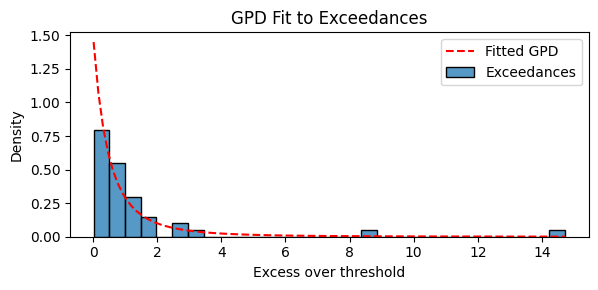

In [14]:
# Histogram vs. Fitted GPD
x = np.linspace(min(exceedances), max(exceedances), 100)
pdf = genpareto.pdf(x, shape, loc, scale)

plt.figure(figsize=(6, 3))
sns.histplot(exceedances, kde=False, stat='density', bins=30, label='Exceedances')
plt.plot(x, pdf, 'r--', label='Fitted GPD')
plt.xlabel('Excess over threshold')
plt.ylabel('Density')
plt.title('GPD Fit to Exceedances')
plt.legend()
plt.tight_layout()
plt.show()

### 3. Change Point Detection 

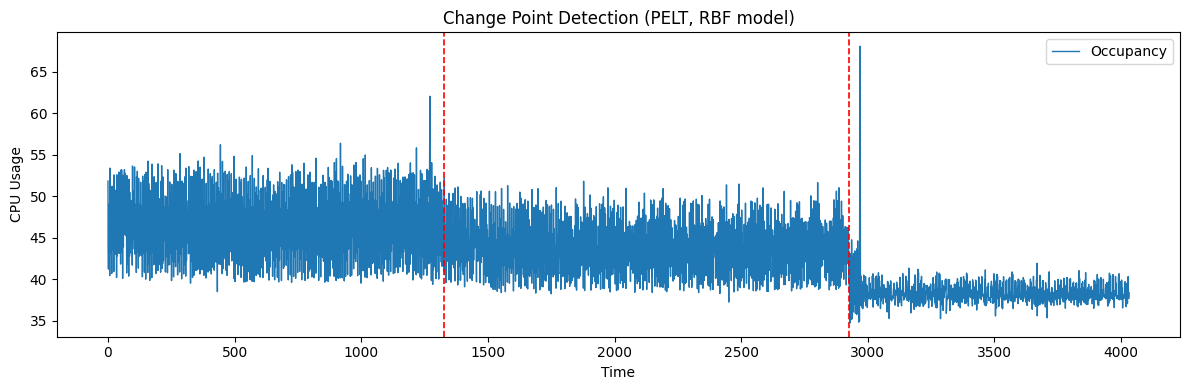

In [11]:
# Change point detection
model = rpt.Pelt(model="rbf").fit(values)
change_indices = model.predict(pen=10)

# Plot full signal with change points
plt.figure(figsize=(12, 4))
plt.plot(df.index, df["value"], label="Occupancy", linewidth=1)

for cp in change_indices[:-1]:  # Exclude final index (end of signal)
    plt.axvline(df.index[cp], color='red', linestyle='--', lw=1.2)

plt.title("Change Point Detection (PELT, RBF model)")
plt.xlabel("Time")
plt.ylabel("CPU Usage")
plt.legend()
plt.tight_layout()
plt.show()


### 4. Would Moving Average Make the Residuals i.i.d.?

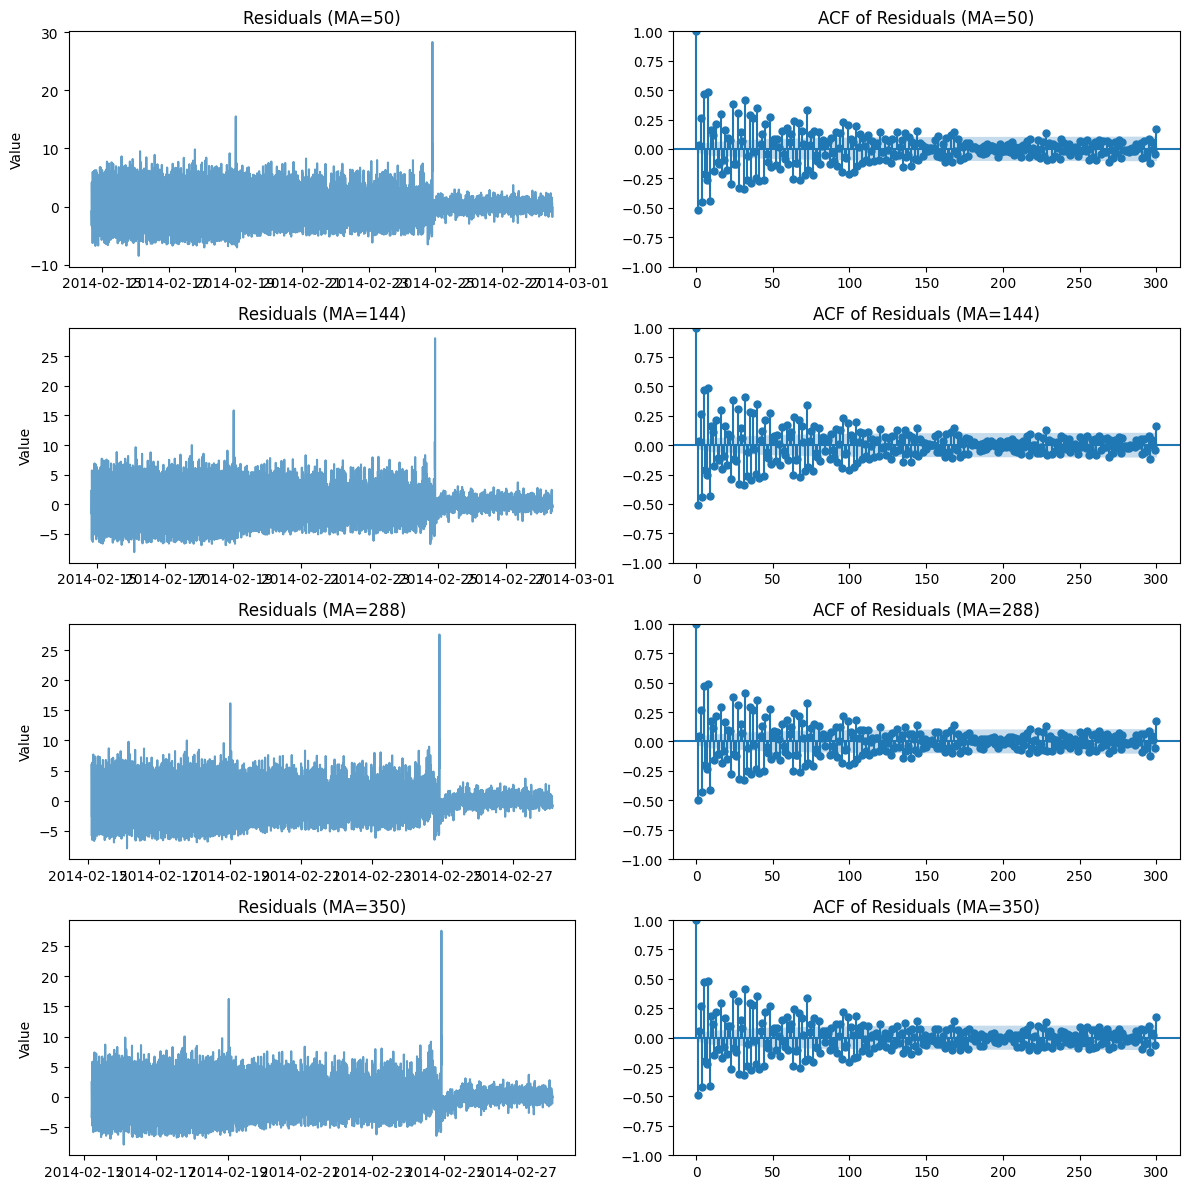

In [10]:
# Prepare he dat 
df2 = pd.read_csv("../../data/raw_data/ec2_cpu_utilization_5f5533.csv", parse_dates=[0])
df2.columns = ["timestamp", "value"]

timestamps = pd.to_datetime(df2.iloc[:, 0])
raw = df2.iloc[:, 1]
raw.index = timestamps

# Define window sizes
windows = [50, 144, 288, 350, ]

# Set up plot grid
fig, axes = plt.subplots(len(windows), 2, figsize=(12, 3*len(windows)), sharex=False)

# Looop over windows
for i, window in enumerate(windows):
    ax_res, ax_acf = axes[i]

    # 4Compute rolling mean & residuals
    rolling_mean = raw.rolling(window=window, center=True).mean()
    residuals    = raw - rolling_mean

    # Plot residuals
    ax_res.plot(residuals, alpha=0.7)
    ax_res.set_title(f"Residuals (MA={window})")
    ax_res.set_ylabel("Value")

    # Plot ACF of residuals
    plot_acf(residuals.dropna(), lags=300, ax=ax_acf)
    ax_acf.set_title(f"ACF of Residuals (MA={window})")

plt.tight_layout()
plt.show()